Helping functions

In [1]:
import os
import numpy as np
import tensorflow as tf
import random as rn

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)

from tensorflow.keras import backend as K

tf.random.set_seed(1234)

from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, f1_score, mean_squared_error, classification_report, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, cross_val_predict, StratifiedKFold, learning_curve, ShuffleSplit
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder, LabelBinarizer, KBinsDiscretizer
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from sklearn import model_selection, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import copy
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sn
import pandas as pd
import scipy as sp
from scipy.special import softmax

import tensorflow.keras.backend as K
plt.rcParams["figure.figsize"] = (12,12)

def mape1(y_true, y_pred):
    """
    Calculates the Mean Absolute Percentage Error (MAPE) between the true and predicted values.
    """
    return 100. * np.mean(np.abs((y_true - y_pred) / y_true))

def print_regression(y_true, y_pred):
    """
    Prints the MAPE, MAE, and MSE between the true and predicted values for regression tasks.
    """
    print('MAPE', mape1(y_true, y_pred))
    print('MAE', mean_absolute_error(y_true, y_pred))
    print('MSE', mean_squared_error(y_true, y_pred))

def print_accuracies(y_test, y_pred):
    """
    Prints the classification report and confusion matrix for classification tasks.
    """
    print(classification_report(y_test, y_pred))
    print('Confusion Matrix')
    cfm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cfm)
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()

def show_activation(input_instance, layer_name, my_model, columns=None):
    """
    Visualizes the activations of a specific layer in the model for a given input instance.
    """
    col = columns
    layer_lookup = dict([(layer.name, layer) for layer in my_model.layers])
    layer_output = layer_lookup[layer_name].output
    partial_net = K.function([my_model.input], [layer_output])
    input_image = input_instance[np.newaxis, ...]
    f, axes = plt.subplots(1, 1)
    axes.imshow(input_image[0, ...])
    axes.set_xticklabels(col)
    plt.show()
    activation = partial_net([input_image])[0]
    activation = activation[0, 0, :]
    sorted_cw1 = np.argsort(-activation)
    activation = [activation[i] for i in sorted_cw1]
    activation = np.asarray(activation)
    sorted_col_cw1 = [col[i] for i in sorted_cw1]
    activation = activation.reshape(1, activation.shape[0])
    sn.heatmap(activation, xticklabels=sorted_col_cw1)
    plt.show()

def plot_importances(clf, columns):
    """
    Plots the feature importances of a trained model.
    """
    if not isinstance(columns, list):
        col = columns.to_list()
    else:
        col = columns
    cw1 = clf.feature_importances_
    sorted_cw1 = np.argsort(cw1)
    cw1 = [cw1[i] for i in sorted_cw1]
    cw1 = np.asarray(cw1)
    sorted_col_cw1 = [col[i] for i in sorted_cw1]
    plt.title('Feature Importances')
    plt.barh(range(len(cw1)), cw1, color='r', alpha=0.5, align='center')
    plt.yticks(np.arange(len(sorted_col_cw1)), sorted_col_cw1)
    plt.xlabel('Relative Importance')
    plt.show()
    print('sorted', sorted_cw1)
    return sorted_cw1

def sigmoid(z):
    """
    Sigmoid activation function.
    """
    return 1/(1 + np.exp(-z))

def relu(x):
    """
    ReLU activation function.
    """
    return np.maximum(x, 0)

def instancewise_weight(X, y, model, layer_name='excitation_1'):
    """
    Calculates the instance-wise weights for a specific layer in the model.
    """
    if X.shape[1] != 1:
        X_ = X.reshape(X.shape[0], 1, X.shape[1])
    else:
        X_ = X
    layer_lookup = dict([(layer.name, layer) for layer in model.layers])
    layer_output = layer_lookup[layer_name].output
    partial_net = K.function([model.input], [layer_output])
    activation = partial_net([X_])[0]
    activation = np.asarray(activation, dtype=np.float32)
    print('activation shape', activation.shape)
    activation = activation.reshape(activation.shape[0], activation.shape[-1])
    return activation

def correlation_attention(weights, classes, columns):
    """
    Calculates the correlation attention matrix for the given weights and classes.
    """
    correlations = []
    for i in range(len(classes)):
        k = classes[i]
        corr_matrix, p_matrix = scipy.stats.spearmanr(weights[i], axis=0)
        correlations.append(corr_matrix)
    correlations = np.asarray(correlations, dtype=np.float32)
    mean_corr = np.mean(np.abs(correlations), axis=0)
    corr_matrix = mean_corr
    print('corr matrix shape', corr_matrix.shape)
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(corr_matrix)] = True
    fig, ax = plt.subplots(figsize=(22, 22))
    ax = sns.heatmap(corr_matrix, mask=mask, annot=False, linewidths=0.1, fmt=".1f", cmap="viridis", xticklabels=columns, yticklabels=columns)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_title("Correlation Matrix of Excited Attention")
    plt.savefig('correlation.svg')
    plt.close()
    print('mean corr shape', mean_corr.shape)
    return mean_corr

def plot_excited_attention_online(X, y, model, columns, regression=False):
    """
    Plots the excited attention weights for each layer in the model.
    """
    layers_weights = {}
    layers_names = []
    col = columns
    excitations = 0
    sns.set(font_scale=0.9)
    for layer in model.layers:
        if 'excitation_' in layer.name:
            excitations += 1
            layers_names.append(layer.name)
            attention = instancewise_weight(X, y, model, layer_name=layer.name)
            class_instances = {}
            for t in range(attention.shape[0]):
                if regression:
                    if 0 not in class_instances:
                        class_instances[0] = []
                    class_instances[0].append(attention[t])
                else:
                    if y[t] not in class_instances:
                        class_instances[y[t]] = []
                    class_instances[y[t]].append(attention[t])
            keys = []
            layers_weights[layer.name] = {}
            for key in class_instances:
                keys.append(key)
                cw2 = np.sum(np.asarray(class_instances[key], dtype=np.float32), axis=0)
                cw2 = np.asarray(cw2).reshape(-1,)
                layers_weights[layer.name][key] = cw2
    fig, axs = plt.subplots(excitations, sharex=True, sharey=True)
    current = 0
    for layer_name in layers_weights:
        weights = []
        keys = []
        for classe in layers_weights[layer_name]:
            keys.append(classe)
            weights.append(layers_weights[layer_name][classe])
        axs[current].set_title('Excited Attention for ' + str(layer_name))
        sn.heatmap(weights, cmap="viridis", xticklabels=col, yticklabels=keys, ax=axs[current])
        current += 1
    plt.savefig('excitation_layer.svg')
    plt.close()
    normalized_att = instancewise_weight(X, y, model, layer_name='hadamard')
    class_instances = {}
    class_instances[0] = []
    for t in range(normalized_att.shape[0]):
        if regression:
            class_instances[0].append(attention[t])
        else:
            if y[t] not in class_instances:
                class_instances[y[t]] = []
            class_instances[y[t]].append(normalized_att[t])
    weights = []
    keys = []
    unhaltered_weights = []
    for key in class_instances:
        keys.append(key)
        cw2 = np.mean(np.abs(np.asarray(class_instances[key], dtype=np.float32)), axis=0)
        cw2 = np.asarray(cw2).reshape(-1,)
        weights.append(cw2)
        unhaltered_weights.append(np.asarray(class_instances[key], dtype=np.float32))
    print(np.asarray(layers_weights).shape)
    sn.heatmap(weights, cmap="viridis", xticklabels=col, yticklabels=keys).set(title='Per Class Importances')
    plt.savefig('per_class_importances.svg')
    plt.close()
    mean_corr = correlation_attention(unhaltered_weights, keys, col)
    minmax = MinMaxScaler()
    cw3 = []
    for key in class_instances:
        diag = np.mean(np.abs(np.asarray(class_instances[key], dtype=np.float32)), axis=0)
        cw3.append(diag)
    cw3 = np.mean(np.abs(cw3), axis=0)
    print('Diagonal', diag)
    sorted_diagonal = np.argsort(cw3.reshape(-1,))
    cw3 = [cw3[i] for i in sorted_diagonal]
    cw3 = np.array(cw3)
    cw3 = softmax(cw3)
    sorted_col = [col[i] for i in sorted_diagonal]
    plt.title('Global Magnitude Feature Importances')
    plt.barh(range(len(cw3)), cw3.reshape(-1,), color='b', alpha=0.6, align='center')
    plt.yticks(np.arange(len(cw3)), sorted_col)
    plt.xlabel('Relative Importance')
    plt.savefig('global_magnitude.svg')
    plt.close()
    width = 0.35
    for key in class_instances:
        fig, ax = plt.subplots()
        ax.set_xlabel('Average Per Class Importances')
        ax.set_title('Normalized Weights For Class ' + str(key))
        previous = None
        actual = np.mean(np.asarray(class_instances[key], dtype=np.float32), axis=0)
        print(actual.shape)
        color = 'blue'
        if key == 1:
            color = 'orange'
        ax.barh(col, actual, width, label=str(key), alpha=0.7, color=color)
        previous = actual
        plt.savefig("normalized_weights_classes_" + str(key) + ".svg")
        plt.show()
        plt.close()
    print('sorted', sorted_diagonal)
    return sorted_diagonal, mean_corr, cw3

class TrainableAttention(tf.keras.layers.Layer):
    """
    Trainable attention layer.
    """
    def __init__(self, **kwargs):
        super(TrainableAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        print(input_shape)
        self._A = tf.Variable(np.identity(input_shape[2])*0.0, trainable=True, name='trainableattentionweights', dtype=tf.float32)
        super(TrainableAttention, self).build(input_shape)

    def call(self, x):
        re = K.dot(x, tf.keras.activations.sigmoid(self._A))
        return re

def multi_excited_block(input_feature, features, num_excitations=None, activation='elu', operation='multiply', dropprob=0.05):
    """
    Multi-excited block for the excited attention model.
    """
    layers = []
    if num_excitations == None:
        num_excitations = max(2, int(np.sqrt(features)))
    ar = np.linspace(1./num_excitations, 1.0, num_excitations)
    print('linspaced', ar)
    for i in range(1, num_excitations+1):
        layers.append(excitation(input_feature, activation=activation, ratio=min(1, ar[i-1]), operation=operation))
    if len(layers) > 1:
        if operation in 'multiply':
            c = tf.keras.layers.Multiply()(layers)
        elif operation in 'add':
            c = tf.keras.layers.Add()(layers)
        elif operation in 'concatenate':
            c = tf.keras.layers.Concatenate(axis=1)(layers)
        elif operation in 'average':
            c = tf.keras.layers.Average()(layers)
    else:
        c = layers[0]
    c = tf.keras.layers.LayerNormalization(name='normalized_attention')(c)
    c = tf.keras.layers.multiply([input_feature, c], name='hadamard')
    c = tf.keras.layers.LayerNormalization(name='normalized_attention2')(c)
    c = TrainableAttention(name='trainableatt')(c)
    c = tf.keras.layers.Dense(features, activation=activation, use_bias=False)(c)
    c = tf.keras.layers.Dense(features, activation=activation, use_bias=False)(c)
    return c

def excitation(input_feature, ratio=1, activation='elu', operation=''):
    """
    Excitation block for the excited attention model.
    """
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    print('channel is', channel)
    initial = 'he_normal'
    se_feature = tf.keras.layers.Reshape((1, channel))(input_feature)
    se_feature = tf.keras.layers.Dense(int(channel * ratio), kernel_initializer=initial, use_bias=True, bias_initializer='zeros')(se_feature)
    se_feature = tf.keras.layers.Activation(activation)(se_feature)
    se_feature = tf.keras.layers.Dense(channel, activation='sigmoid', kernel_initializer=initial, use_bias=True, bias_initializer='zeros', name='excitation_' + str(round(ratio, 3)))(se_feature)
    if K.image_data_format() == 'channels_first':
        se_feature = tf.keras.layers.Permute((3, 1))(se_feature)
    return se_feature

def get_regression(input_shape, operation='average', activation='swish', optimizer=None):
    """
    Returns a regression model using the excited attention blocks.
    """
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_mae', mode='min', save_best_only=True)
    source = tf.keras.Input(shape=input_shape)
    if optimizer== None:
        lr = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=50, decay_rate=0.9, staircase=False)
        optimizer = tf.keras.optimizers.Adam(lr)
    attention = multi_excited_block(source, input_shape[-1], activation=activation, operation=operation, dropprob=0.05)
    if operation in 'concatenate':
        flat = tf.keras.layers.Flatten()(attention)
        dense2 = tf.keras.layers.Dense(1, activation='linear')(flat)
    else:
        dense2 = tf.keras.layers.Dense(1, activation='linear')(attention)
    model = tf.keras.Model(inputs=[source], outputs=[dense2])
    model.compile(optimizer, loss=tf.keras.losses.MAE, metrics=['mae', 'mape', 'mse'], run_eagerly=False)
    return model

def get_classification(classes, shape, operation='average', activation='elu', optimizer=None):
    """
    Returns a classification model using the excited attention blocks.
    """
    source = tf.keras.Input(shape=shape)
    print('shape is', shape)
    attention = multi_excited_block(source, shape[-1], activation=activation, operation=operation, dropprob=0.05)
    flat = tf.keras.layers.Flatten()(attention)
    dense2 = tf.keras.layers.Dense(classes, activation='softmax')(flat)
    model = tf.keras.Model(inputs=[source], outputs=[dense2])
    if optimizer== None:
        lr = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=50, decay_rate=0.9, staircase=False)
        optimizer = tf.keras.optimizers.Adam(lr)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'AUC'], run_eagerly=False)
    return model


In [2]:
from sklearn.utils.multiclass import unique_labels
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

class ExcitedAttentionClassifier:
    """
    Classifier using excited attention mechanism.
    """

    def __init__(self, input_shape, classes, operation='add', activation='elu', optimizer=None, epochs=100, batch_size=64):
        """
        Initialize the classifier.
        """
        self.learner = get_classification(classes, input_shape, operation=operation, activation=activation, optimizer=optimizer)
        self.epochs = epochs
        self.batch_size = batch_size

    def fit(self, X, y, epochs=100, batch_size=64, validation_split=0.2, shuffle=True, verbose=0, callbacks=None, validation_data=None):
        """
        Train the classifier on the given data.
        """
        print('y shape', y.shape)
        if len(y.shape) < 2:
            y = to_categorical(y)
        if y.shape[-1] < 2:
            y = to_categorical(y)

        if callbacks is None:
            callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)]

        if len(X.shape) < 3:
            self.X = X.reshape(X.shape[0], 1, X.shape[1])
        else:
            self.X = X

        self.classes_ = unique_labels(y)

        if validation_data is None:
            self.learner.fit(self.X, y, epochs=self.epochs, batch_size=self.batch_size, validation_split=validation_split, shuffle=shuffle, verbose=verbose, callbacks=callbacks)
        else:
            self.learner.fit(self.X, y, epochs=self.epochs, batch_size=self.batch_size, validation_data=validation_data, shuffle=shuffle, verbose=verbose, callbacks=callbacks)

    def predict_proba(self, X_, usePandas=False):
        """
        Make probability predictions on the data.
        """
        if usePandas:
            if len(X_.shape) < 3:
                t = X_.values.reshape(X_.values.shape[0], 1, X_.values.shape[1])
            else:
                t = X_
        else:
            if len(X_.shape) < 3:
                t = X_.reshape(X_.shape[0], 1, X_.shape[1])
            else:
                t = X_

        print('predict', t.shape)

        if usePandas:
            return pd.DataFrame(self.learner.predict(t), index=X_.index)
        else:
            return self.learner.predict(t)

    def predict(self, X_, use_pandas=False):
        """
        Make predictions on the data.
        """
        if len(X_.shape) < 3:
            X_ = X_.reshape(X_.shape[0], 1, X_.shape[1])

        return np.argmax(self.learner.predict(X_), axis=1)

    def load_weights(self, file):
        """
        Load pretrained weights into the model.
        """
        self.learner.load_weights(file)



Classification example

shape is (1, 30)
linspaced [0.2 0.4 0.6 0.8 1. ]
channel is 30
channel is 30
channel is 30
channel is 30
channel is 30
(None, 1, 30)
y shape (455, 2)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        43
           1       0.97      0.94      0.96        71

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114

Confusion Matrix


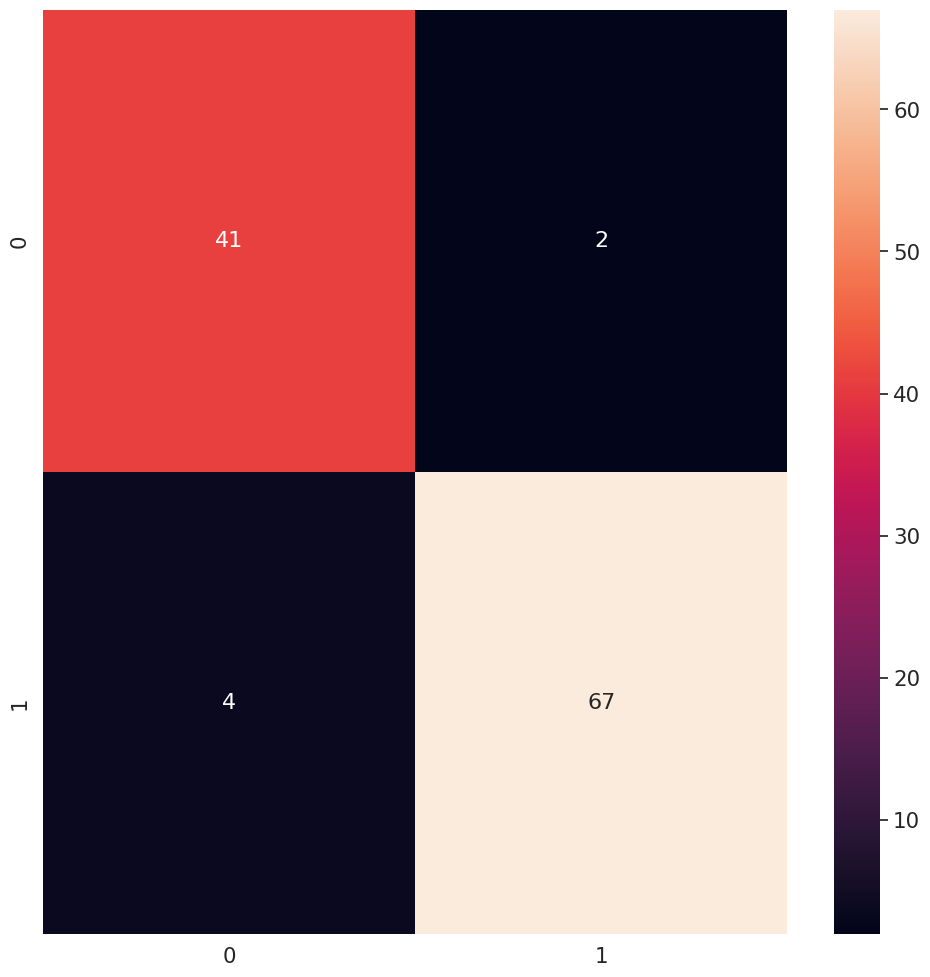

In [5]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


# Load data
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape input
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

input_shape = (1, X_train.shape[2])

# One-hot encode labels
y_train = to_categorical(y_train)

# Define model checkpoint callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                               save_weights_only=False,
                                                               monitor='val_accuracy',
                                                               mode='max',
                                                               save_best_only=True)

# Create and train model
exc = ExcitedAttentionClassifier(input_shape, len(np.unique(y_train)), operation='multiply', optimizer=None)
exc.fit(X_train, y_train, epochs=100, batch_size=128, shuffle=False, validation_split=0.2, callbacks=[model_checkpoint_callback])

# Evaluate model
y_pred = exc.predict(X_test)
print_accuracies(y_test, y_pred)


Additional helper functions for Explainable Artificial Intelligence plots



In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np

# Adjust overall font scale for seaborn plots
# Adjust overall font scale for seaborn plots
sns.set(font_scale=0.7, style="whitegrid")  # Decrease font_scale to reduce overall font size

def plot_heatmap(data, xlabels, ylabels, title, filename):
    # Determine optimal rotation based on the number of features
    rotation_angle = 45 if len(xlabels) <= 20 else 90  # Rotate more for more features to save space

    fig, ax = plt.subplots(figsize=(20, 15))  # Increase figure size for better visibility

    # Create the heatmap
    sns.heatmap(data, ax=ax, cmap="viridis", xticklabels=xlabels, yticklabels=ylabels,
                annot=False, fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5})

    # Setting labels and title with adjusted font size
    ax.set_title(title, fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation_angle, ha='right', fontsize=8)  # Decrease fontsize and adjust angle
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

    # Adjust layout to make room for label rotation
    plt.tight_layout()

    # Save the figure
    plt.savefig(filename, format='svg')
    plt.close()


def plot_barh(values, y_labels, title, save_as, color='b', alpha=0.6):
    plt.figure(figsize=(12, 10))
    plt.barh(range(len(values)), values, color=color, alpha=alpha, align='center')
    plt.yticks(np.arange(len(values)), y_labels, fontsize=6)  # Adjust fontsize here
    plt.xlabel('Relative Importance')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_as)
    plt.close()

def plot_sorted_stacked_barh(values_dict, y_labels, title, save_as):
    aggregated_weights = np.array(values_dict[0]) + np.array(values_dict[1])
    sorted_indices = np.argsort(aggregated_weights)[::-1]
    sorted_y_labels = [y_labels[i] for i in sorted_indices]
    sorted_values_0 = [values_dict[0][i] for i in sorted_indices]
    sorted_values_1 = [values_dict[1][i] for i in sorted_indices]

    plt.figure(figsize=(12, 10))
    bar_width = 0.35
    r1 = np.arange(len(sorted_values_0))
    r2 = [x + bar_width for x in r1]

    plt.barh(r1, sorted_values_0, color='blue', alpha=0.6, align='center', height=bar_width, label='0')
    plt.barh(r2, sorted_values_1, color='orange', alpha=0.6, align='center', height=bar_width, label='1')
    y_tick_positions = [(r1[i] + r2[i]) / 2 for i in range(len(r1))]
    plt.yticks(y_tick_positions, sorted_y_labels, fontsize=6)  # Adjust fontsize here
    plt.xlabel('Relative Importance')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y')
    plt.savefig(save_as)
    plt.close()

# Example usage
# Assuming your data preparation and other functions are correctly set up,
# You can use these functions for plotting.



Call for generating Explainable AI plots in SVG format

activation shape (455, 1, 30)
activation shape (455, 1, 30)
activation shape (455, 1, 30)
activation shape (455, 1, 30)
activation shape (455, 1, 30)
activation shape (455, 1, 30)
()
corr matrix shape (30, 30)
mean corr shape (30, 30)
Diagonal [0.25203362 1.1319592  0.27819762 0.25491378 0.22455722 0.20480144
 0.13313515 0.15964472 0.17453009 0.2348178  0.20556922 0.25530696
 0.18878151 1.7095016  0.15169507 0.31772473 0.25336722 0.27969632
 0.16880277 0.44228816 0.09107634 0.45724785 0.29864174 0.305152
 0.7065051  0.16442052 0.3847861  0.31101274 0.28954464 0.17503715]
(30,)


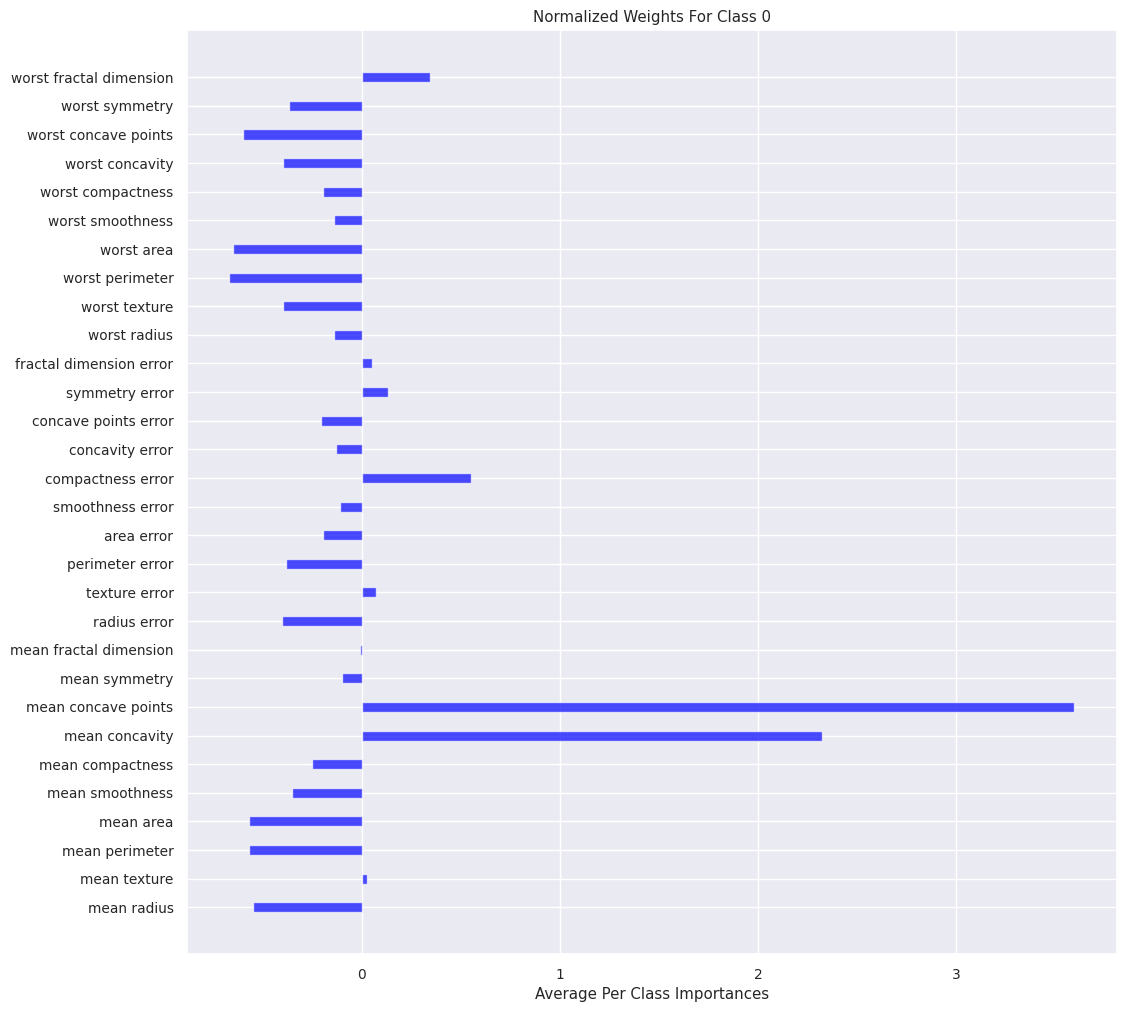

(30,)


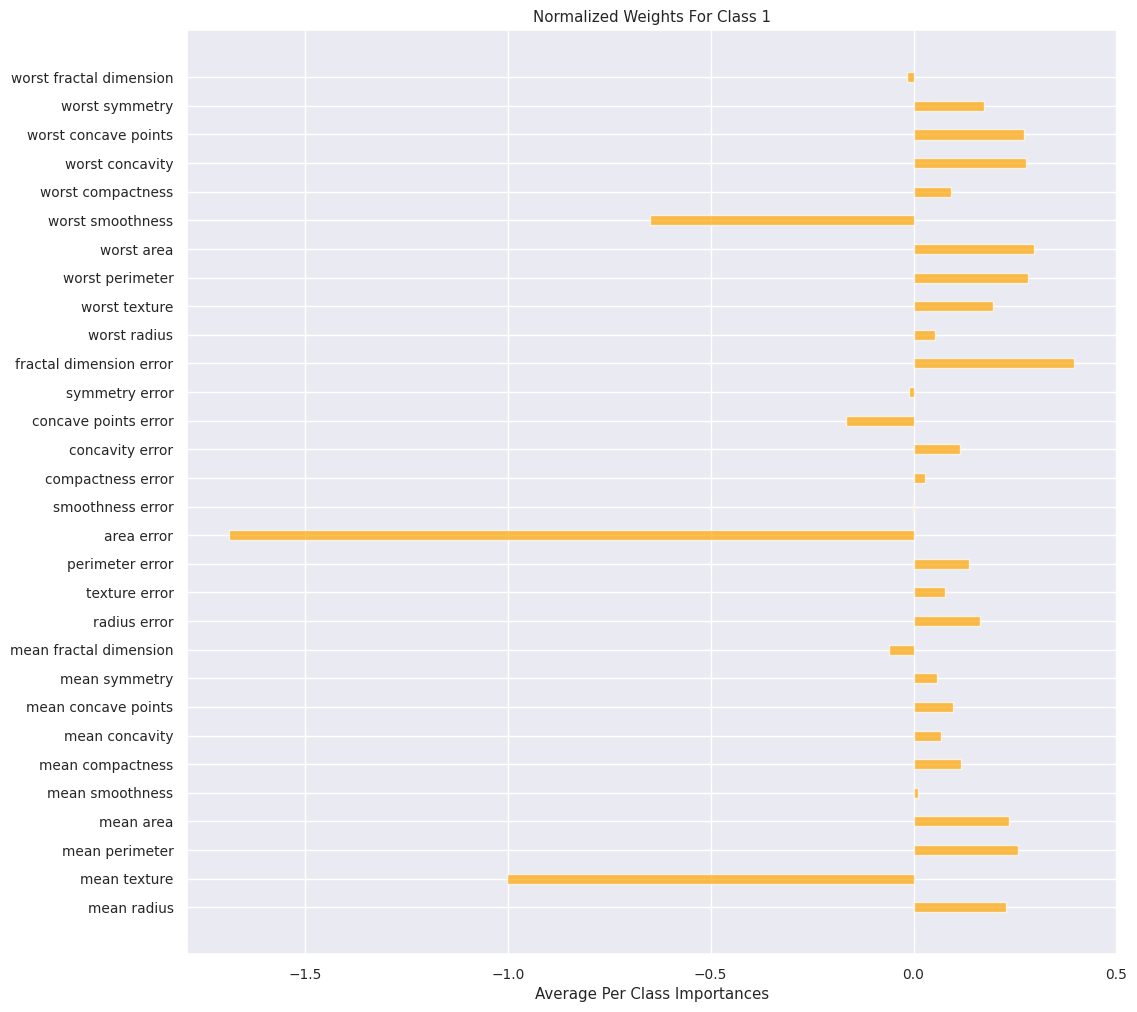

sorted [20 14  8 16 11 25 18  9 29  4 17 12  5 10 19 26  0 28  3  2 24 27 22 21
 23 15  1 13  6  7]


In [16]:
best_features_indexes, corr, cw3 = plot_excited_attention_online(X_train,np.argmax(y_train,axis=1),exc.learner,cancer['feature_names'].tolist())